In [1]:
from tensorflow.keras.datasets import cifar100
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Load Data
(train_data, _train_label), (test_data, _test_label) = cifar100.load_data()

#Parse the number
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

#normalize data
train_data = train_data / 255
test_data = test_data / 255

train_label = to_categorical(_train_label)
test_label = to_categorical(_test_label)

169009152/169001437 [==============================] - 4s 0us/step


In [3]:
class Inception(layers.Layer):
    def __init__(self, c1, c2, c3, c4):
        super().__init__()

        self.L1 = Conv2D(c1, kernel_size = 1, activation = 'relu', padding = 'same')

        self.L4_1 = MaxPool2D(pool_size = (1,1), strides = 1)
        self.L4_2 = Conv2D(c4, kernel_size = 1, activation = 'relu')

        self.L2_1 = Conv2D(c2[0], kernel_size = 1, strides = (1,1),activation = 'relu', padding = 'same')
        self.L2_2 = Conv2D(c2[1], kernel_size = 3, activation = 'relu', padding = 'same')
        
        self.L3_1 = Conv2D(c3[0], kernel_size = 1, activation = 'relu')
        self.L3_2 = Conv2D(c3[1], kernel_size = 3, activation = 'relu', padding = 'same')
        self.L3_3 = Conv2D(c3[1], kernel_size = 3, activation = 'relu', padding = 'same')

        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.bn3 = BatchNormalization()

    def call(self, x):
        out1 = self.L1(x)
        out2 = self.L2_2(self.bn1(self.L2_1(x)))
        out3 = self.L3_3(self.bn3(self.L3_2(self.bn2(self.L3_1(x)))))
        out4 = self.L4_2(self.L4_1(x))

        return tf.concat([out1, out2, out3, out4], axis = 3)

In [4]:
output1 = Sequential()
output1.add(Conv2D(64,kernel_size = 7, strides = (2,2), padding = 'same', activation = 'relu'))
output1.add(MaxPool2D(pool_size = (3,3), strides = 1))

output2 = Sequential()
output2.add(Conv2D(64, kernel_size = 1, strides = (1,1), activation = 'relu'))
output2.add(BatchNormalization())
output2.add(Conv2D(192, kernel_size = 3, strides = (1,1), padding = 'same', activation = 'relu'))
output2.add(MaxPool2D(pool_size = (3,3), strides = 2, padding = 'same'))

output3 = Sequential()
output3.add(Inception(64,(96,128),(16,32),32))
output3.add(Inception(128,(128,192),(32,96),64))
output3.add(MaxPool2D(pool_size = (3,3), strides = 2, padding = 'same'))

output4 = Sequential()
output4.add(Inception(192,(96,208),(16,48),64))
output4.add(Inception(160,(112,224),(24,64),64))
output4.add(Inception(128,(128,256),(24,64),64))
output4.add(Inception(112,(144,288),(32,64),64))
output4.add(Inception(256,(160,320),(32,128),128))
output4.add(MaxPool2D(pool_size = (3,3), strides = 2, padding = 'same'))

output5 = Sequential()
output5.add(Inception(256,(160,320),(32,128),128))
output5.add(Inception(384,(192,384),(48,128),128))
output5.add(MaxPool2D(pool_size = (3,3), strides = 2, padding = 'same'))

net = Sequential()
net.add(output1)
net.add(output2)
net.add(output3)
net.add(output4)
net.add(output5)
net.add(Flatten())
net.add(Dense(100, activation = 'softmax'))

Epoch 1/10
2500/2500 [==============================] - 46s 19ms/step - loss: 1.8011 - accuracy: 0.4990
Epoch 2/10
2500/2500 [==============================] - 45s 18ms/step - loss: 1.7148 - accuracy: 0.5191
Epoch 3/10
2500/2500 [==============================] - 46s 18ms/step - loss: 1.6104 - accuracy: 0.5427
Epoch 4/10
2500/2500 [==============================] - 45s 18ms/step - loss: 1.5255 - accuracy: 0.5627
Epoch 5/10
2500/2500 [==============================] - 45s 18ms/step - loss: 1.4463 - accuracy: 0.5778
Epoch 6/10
2500/2500 [==============================] - 45s 18ms/step - loss: 1.3555 - accuracy: 0.6020
Epoch 7/10
2500/2500 [==============================] - 45s 18ms/step - loss: 1.2873 - accuracy: 0.6172
Epoch 8/10
2500/2500 [==============================] - 45s 18ms/step - loss: 1.2108 - accuracy: 0.6385
Epoch 9/10
2500/2500 [==============================] - 45s 18ms/step - loss: 1.1450 - accuracy: 0.6557
Epoch 10/10
2500/2500 [==============================] - 46s 18m

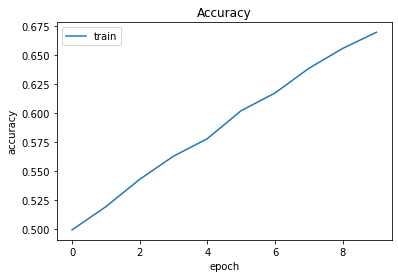

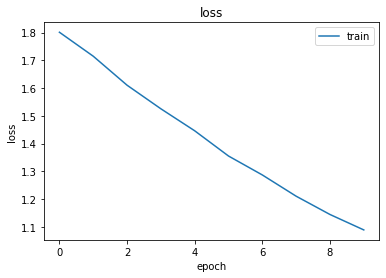

In [8]:
opt = keras.optimizers.Adam(learning_rate = 0.001)
net.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
result = net.fit(train_data,train_label, batch_size = 20, epochs = 10)
print(net.summary())
predict = net.predict(test_data)
predict = np.argmax(predict, axis = 1)
test_label = np.argmax(test_label, axis = 1)
print(classification_report(y_true = test_label, y_pred = predict))
plt.plot(result.history['accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'])
plt.show()

plt.plot(result.history['loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'])
plt.show()